IF NEEDED INSTALL MALA (works in Colab). Install Pytorch from webpage instructions (not needed in COLAB)

In [1]:
"""!git clone https://github.com/mala-project/mala.git
%cd mala
!pip install -e .
%cd ."""

'!git clone https://github.com/mala-project/mala.git\n%cd mala\n!pip install -e .\n%cd .'

Loading the modules

In [5]:
# MALA itself.

import mala

# We would like to visualize simple plots.
# The font size can sometimes be a bit small for Jupyter Notebooks.

import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 22}
matplotlib.rc('font', **font)

# For the data paths.
from os.path import join as pj

# Only for the prediction down below.
from ase.io import read

# To do some timings down below.
from time import time
import numpy as np
import mala
import subprocess
import ase
import ase.io.espresso
from ase import Atoms
from ase.visualize import view
import os
from os.path import join as pj
import matplotlib.pyplot as plt
import re
import random
import time

If problems with MALA, Check Pytorch Installation with

In [6]:
 import torch

MALA data generation can be performed with the Quantum ESPRESSO package. Some changes to this open source package were necessary to enable the correct sampling of the LDOS. The current development branch of Quantum ESPRESSO includes those - beginning with Quantum ESPRESSO version 7.2 (to be released in ~June 2023) users can simply download the latest QE version and perform data generation.

Data generation is two-fold: First, one creates a set of atomic position via a regular DFT-MD simulation at the conditions of interest. This can be done with any suitable code, such as VASP, QE, etc. Secondly, one performs DFT simulations to access the LDOS.

The test system  here will be a simply beryllium system at room temperature consisting of 2 beryllium atoms. Atomic configurations have been sampled beforehand. We will start with the DFT simulation. 

Write hundreds of lines of parameter statement in each python script is not exactly maintainable. Therefore MALA provides a .json interface.


In [7]:
parameters = mala.Parameters.load_from_file("mala_parameters_01.json")

In [8]:
parameters.show()

---     All parameter MALA needs to perform its various tasks. ---
comment        : My first parameters.
manual_seed    : None
use_gpu        : True
device         : cuda:0
use_horovod    : False
use_mpi        : False
verbosity      : 1
openpmd_configuration: {}
openpmd_granularity: 1
use_lammps     : True
---     Parameters necessary for constructing a neural network. ---
	nn_type        : feed-forward
	layer_sizes    : [10, 10, 10]
	layer_activations: ['Sigmoid']
	loss_function_type: mse
	num_hidden_layers: 1
	no_hidden_state: False
	bidirection    : False
	dropout        : 0.1
	num_heads      : 10
---     Parameters necessary for calculating/parsing input descriptors. ---
	descriptor_type: Bispectrum
	lammps_compute_file: 
	descriptors_contain_xyz: True
	use_z_splitting: True
	number_y_planes: 0
	bispectrum_twojmax: 10
	rcutfac        : 4.67637
	atomic_density_cutoff: 4.67637
	snap_switchflag: 1
	use_atomic_density_energy_formula: False
	atomic_density_sigma: None
	minterpy_point_l

In [9]:
data_path = r"C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be"
snapshot_path =  r"C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots"

We'll now convert the data to MALA DATA (maxiter must be the same as QE files) 
THIS WILL TAKE LONG AS FUCK because no LAMMPS is compiled to work with MALA, be warned. There is a multiproccesing script in Github

In [10]:
data_converter = mala.DataConverter(parameters)
maxiter = 8
for i in range(1, maxiter):
    time1 = time.time()
    data_converter.add_snapshot(descriptor_input_type="espresso-out",
                                descriptor_input_path=os.path.join(data_path,f"Be{i}.pw.out"),
                                target_input_type=".cube",
                                target_input_path=os.path.join(f"tmp.pp0*Be{i}_ldos.cube"))
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")
print("CONVERTING SNAPSHOTS")
time1 = time.time()
#UNCOMMENT IF WANNA TRY HERE
#data_converter.convert_snapshots("./snapshots/", naming_scheme="Be_snapshot*.npy")


Disabling z-splitting for preprocessing.
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
CONVERTING SNAPSHOTS


Visualizing and reproducing output data

Before we train a model, it is a good idea to think about which metric is important, i.e., how do we test if a model is good?

In essence, the advantage of MALA is the access to multiple observables. Two easily accesible metrics are the density of states (DOS) and the band energy. We will now see how to calculate them from the LDOS (the actual DFT LDOS in this case) so we can do the same after model training to test our models.

For this, we first have to make sure the correct LDOS parameters are used.


In [11]:
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5

Now we can create an LDOS calculator and directly populate it with the LDOS data from the data set.

In [12]:
ldos_calculator = mala.LDOS.from_numpy_file(parameters, pj(snapshot_path, "Be_snapshot1.out.npy"))


Afterwards, we have to read in some additional information from the simulation data (size of the real space grid, temperature, etc.).

In [13]:
ldos_calculator.read_additional_calculation_data(pj(data_path, "Be1.pw.out"))
print(ldos_calculator.density_of_states)
print(ldos_calculator.energy_grid)
#print(ldos_calculator.density_of_states)

[0.30867848 0.40815389 0.50501234 0.58352213 0.63074861 0.63961693
 0.60908288 0.54389667 0.45474118 0.35631671 0.26284809]
[-5.  -2.5  0.   2.5  5.   7.5 10.  12.5 15.  17.5 20. ]


Now we can access the DOS and the band energy as properties of the calculator object.

-4.613344314276244


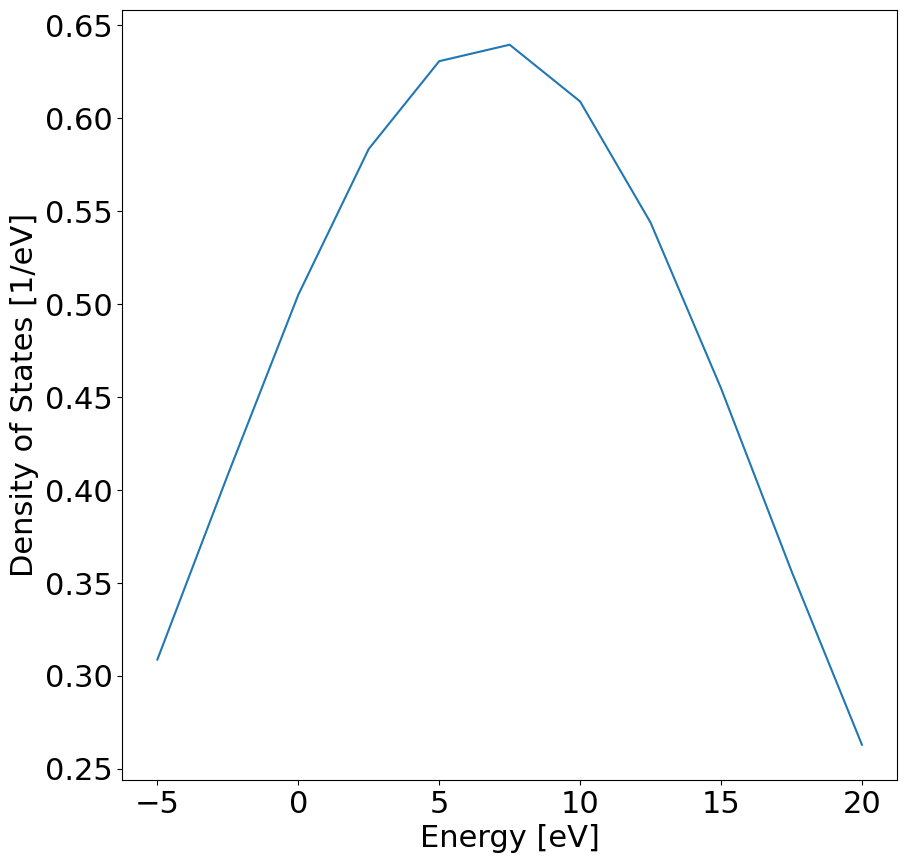

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states)

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")

print(ldos_calculator.band_energy)

In [15]:
parameters.verbosity = 2
parameters.manual_seed = 2024

Now we have to add data, we have to choose between training and test data

In [16]:

def split_data(maxiter, prop, prop2):
    data = np.arange (1,maxiter +1)
    random.shuffle(data)  # Shuffle the data randomly
    split_80 = int(len(data) * prop)  # Calculate the index for the 80% split
    split_20 = int(len(data) * prop2)  # Calculate the index for the 20% split
    train_data = data[:split_80]  # Extract the first 80% of the shuffled data
    test_data = data[split_80:split_80+split_20 ]  # Extract the next 20% of the shuffled data
    validation_data = data[split_80+split_20:]  # Extract the remaining 20% of the shuffled data
    return train_data, test_data, validation_data
    


We'll now test in a very basic system, a 2 atom Si, where we only change Atomic Positions in a +-0.1 crystallographic axes randomly
Akin to a relax calculation in QE

In [19]:
data_path = r"C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\SiPositions"
snapshot_path =  r"C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\SiPositions\snapshots"

In [20]:
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5
ldos_calculator = mala.LDOS.from_numpy_file(parameters, pj(snapshot_path, "Si_snapshot1.out.npy"))
ldos_calculator.read_additional_calculation_data(pj(data_path, "Si1.pw.out"))
print(ldos_calculator.density_of_states)
print(ldos_calculator.energy_grid)
#print(ldos_calculator.density_of_states)

[0.46287329 0.6115053  0.76945438 0.92349997 1.05818843 1.15674994
 1.20294891 1.18431658 1.09682349 0.94970734 0.76641084]
[-5.  -2.5  0.   2.5  5.   7.5 10.  12.5 15.  17.5 20. ]


Let's plot the DOS

0.4988250326172263


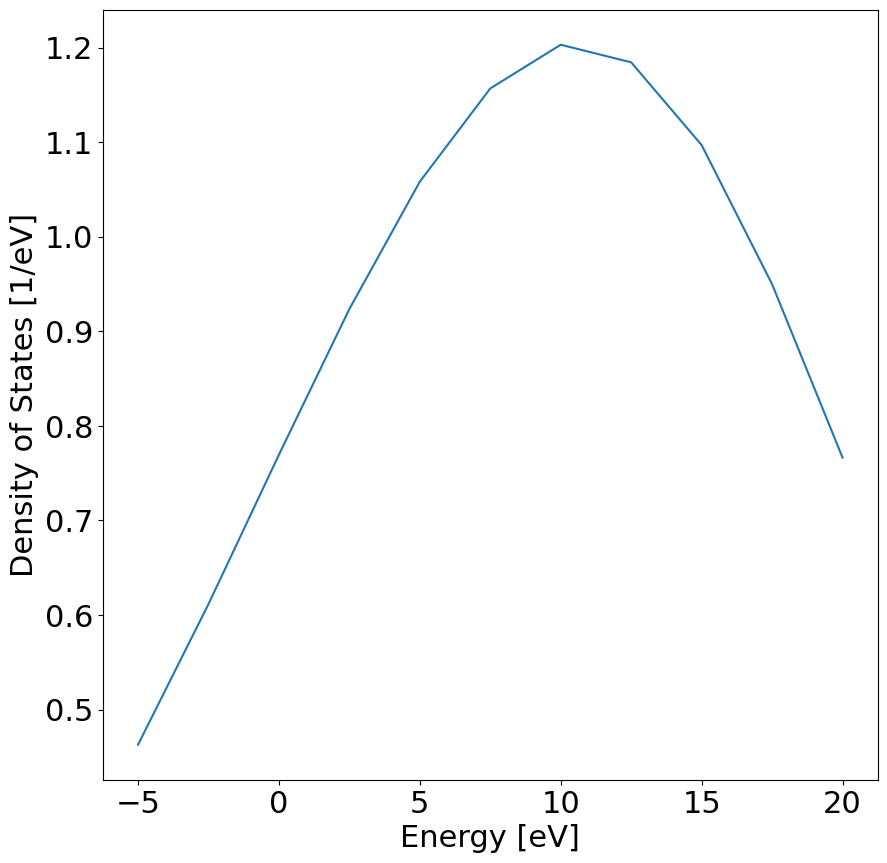

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states)

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")

print(ldos_calculator.band_energy)

Now we'll Load all the Si Files, and split data (watch out for number of snapshots and props)

In [166]:
parameters = mala.Parameters.load_from_file("mala_parameters_01.json")
data_handler = mala.DataHandler(parameters)
prop = 0.7 # proportion of training data
prop2 = 0.2 #proportion of validation data
maxiter = 12 # number of .in snapshots
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data)
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")
    
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()


No data rescaling will be performed.
No data rescaling will be performed.
[ 4  6 11  1 12  7  2  3] [5 8] [10  9]
DONE ADDING DATA ITERATION 1 of 11 in 0.00s
DONE ADDING DATA ITERATION 2 of 11 in 0.00s
DONE ADDING DATA ITERATION 3 of 11 in 0.00s
DONE ADDING DATA ITERATION 4 of 11 in 0.00s
DONE ADDING DATA ITERATION 5 of 11 in 0.00s
DONE ADDING DATA ITERATION 6 of 11 in 0.00s
DONE ADDING DATA ITERATION 7 of 11 in 0.00s
DONE ADDING DATA ITERATION 8 of 11 in 0.00s
DONE ADDING DATA ITERATION 9 of 11 in 0.00s
DONE ADDING DATA ITERATION 10 of 11 in 0.00s
DONE ADDING DATA ITERATION 11 of 11 in 0.00s
DONE ADDING DATA ITERATION 12 of 11 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking targets file  Si_snapshot1.out.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking descriptor file  Si_snapshot2.in.npy at C:\Users\Pablo\D

Now we  can train the Network. It is a basic Network with 100 neurons. Takes about 3-4 minutes. Much faster if GPU

In [167]:
parameters.verbosity = 2
parameters.use_gpu = True #if crashing or error just delete below parameters, set gpu to false and rerun cell above. First error just run cell above
#parameters.running.use_graphs = True  #NVIDIA things. Pretty Buggy but performant when it wants to
parameters.data.use_fast_tensor_data_set = True #Watch out if AMD 

parameters.network.layer_sizes = [data_handler.input_dimension,
                                  100, data_handler.output_dimension]
parameters.running.max_number_epochs = 2
parameters.running.early_stopping_epochs = 10
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()

batch 1000, validation avg time: 0.00046248459815979 validation avg throughput: 21622.34167319225
batch 2000, validation avg time: 0.0004381480216979981 validation avg throughput: 22823.337102484267
batch 3000, validation avg time: 0.00044364404678344727 validation avg throughput: 22540.59323573258
batch 4000, validation avg time: 0.0004431004524230957 validation avg throughput: 22568.24597067094
Initial Guess - validation data loss:  0.20614972753717906
batch 1000, train avg time: 0.0011142678260803224 train avg throughput: 8974.50304670212
batch 2000, train avg time: 0.001105262041091919 train avg throughput: 9047.628189710309
batch 3000, train avg time: 0.0011702957153320313 train avg throughput: 8544.848852294434
batch 4000, train avg time: 0.0011175711154937744 train avg throughput: 8947.976429743103
batch 5000, train avg time: 0.0011923863887786865 train avg throughput: 8386.543233056022
batch 6000, train avg time: 0.0012469112873077393 train avg throughput: 8019.816727773343
bat

We can test this by using the Tester class. The class works similar to the Trainer class. We add data, push them through the model, and then use the results to perform calculations.

We just have to make sure that the LDOS is correctly integrated by setting the appropriate parameters. Then we can add data to test. We should always test on data different from the one we trained on. Also, we now have to specify the corresponding calculation output, since we may need this for integration.

In [200]:
data_handler.clear_data()
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5

for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot5.in.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking targets file  Si_snapshot5.out.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.
Had to readjust batch size from 10 to 12
Error calculating observable: band_energy for snapshot 0


Results are given in error of ev/atom

In [172]:
results

{'band_energy': [1.377939076854581, -0.8948468259232598]}

Let's do the Same with a much bigger network, for better results

In [233]:
parameters = mala.Parameters.load_from_file("mala_parameters_01.json")

data_handler = mala.DataHandler(parameters)
prop = 0.8 # proportion of training data
prop2 = 0.1 #proportion of validation data
maxiter = 12 # number of .in snapshots
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data)
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")
    
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()


No data rescaling will be performed.
No data rescaling will be performed.
[ 6  8 12  9  7 10 11  2  4] [3] [1 5]
DONE ADDING DATA ITERATION 1 of 11 in 0.00s
DONE ADDING DATA ITERATION 2 of 11 in 0.00s
DONE ADDING DATA ITERATION 3 of 11 in 0.00s
DONE ADDING DATA ITERATION 4 of 11 in 0.00s
DONE ADDING DATA ITERATION 5 of 11 in 0.00s
DONE ADDING DATA ITERATION 6 of 11 in 0.00s
DONE ADDING DATA ITERATION 7 of 11 in 0.00s
DONE ADDING DATA ITERATION 8 of 11 in 0.00s
DONE ADDING DATA ITERATION 9 of 11 in 0.00s
DONE ADDING DATA ITERATION 10 of 11 in 0.00s
DONE ADDING DATA ITERATION 11 of 11 in 0.00s
DONE ADDING DATA ITERATION 12 of 11 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking targets file  Si_snapshot1.out.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking descriptor file  Si_snapshot2.in.npy at C:\Users\Pablo\Do

We'll also rescale all descriptors with Row Standardization to improve performance

In [234]:
parameters.use_gpu = True #if crashing or error just delete below parameters, set gpu to false and rerun cell above. First error just run cell above
#parameters.running.use_graphs = True  #NVIDIA things. Pretty Buggy but performant when it wants to
parameters.data.use_fast_tensor_data_set = True #Watch out if AMD 
parameters.running.learning_rate = 0.5
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  500,data_handler.output_dimension]
parameters.data.input_rescaling_type = "feature-wise-standard"
parameters.running.max_number_epochs = 10
parameters.running.early_stopping_epochs = 4
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()

Initial Guess - validation data loss:  0.2322090318140896
Epoch 0: validation data loss: 2.5120589849804037e-05
Epoch 1: validation data loss: 1.4108409898547795e-05
Epoch 2: validation data loss: 1.0346955185973425e-05
Epoch 3: validation data loss: 8.55681758550002e-06
Epoch 4: validation data loss: 7.3994799959855e-06
Epoch 5: validation data loss: 6.661589617554454e-06
Epoch 6: validation data loss: 6.3055729279752635e-06
Epoch 7: validation data loss: 5.945196894348645e-06
Epoch 8: validation data loss: 5.557731677676581e-06
Epoch 9: validation data loss: 5.20435807617559e-06
Final validation data loss:  5.20435807617559e-06


In [235]:
data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()
results

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot3.in.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking targets file  Si_snapshot3.out.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.
Had to readjust batch size from 10 to 12


{'band_energy': [-0.06385462664585617]}

Let's save the data and then calculate DOS from it

In [236]:
trainer.save_run("Si1_model")

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot3.in.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking targets file  Si_snapshot3.out.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


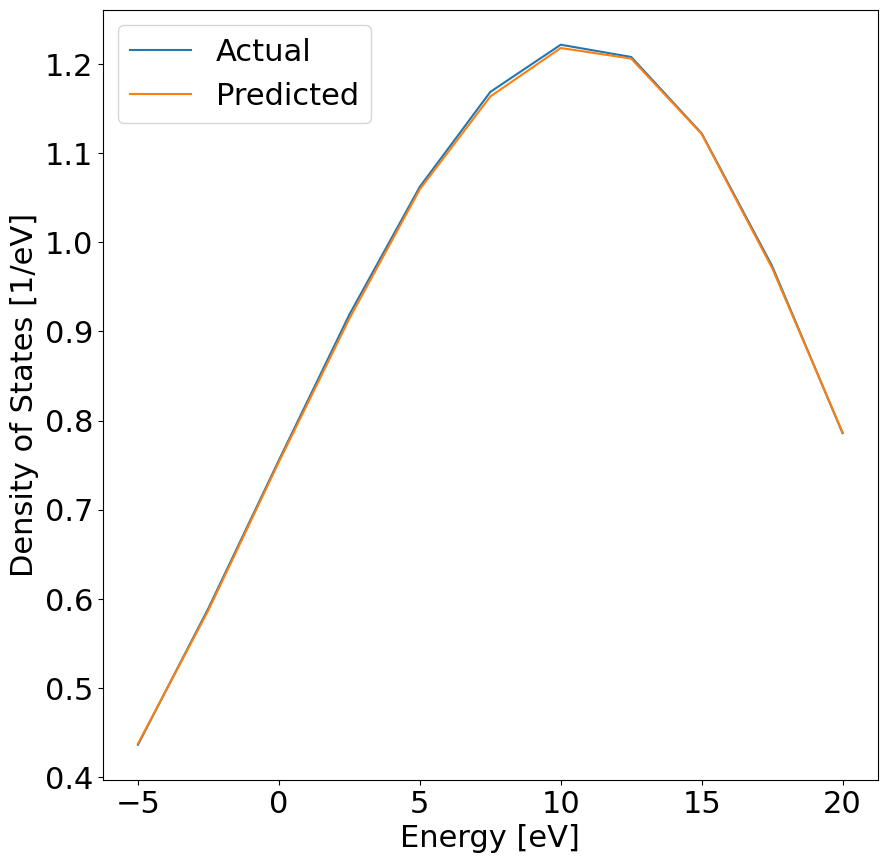

In [237]:
parameters, network, data_handler, tester = mala.Tester.load_run("Si1_model")
data_handler.clear_data()
data_handler.add_snapshot(f"Si_snapshot{test_data[0]}.in.npy", snapshot_path,
                              f"Si_snapshot{test_data[0]}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{test_data[0]}.pw.out"))
data_handler.prepare_data(reparametrize_scaler=False)
actual_ldos, predicted_ldos = tester.predict_targets(0)
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()


Let's Show now how we can optimize network Parameters automatically. There are multiple algorithms implemented, but we will focus on the `optuna` library, to which MALA provides an interface. The idea is easy: we give MALA a set of hyperparameters to optimize, fix the others, give it some data and let optuna do its work. Optuna internally uses elaborate algorithms to determine optimal hyperparameters from observed data.

Kinda works, takes too long and buggy (still in development it seems), decided not to push this part Go after hyperparameter opt for Be and Si Cell parameters

In [39]:
"""
parameters.verbosity = 2
parameters.manual_seed = 2024
parameters.data.input_rescaling_type = "feature-wise-standard"
parameters.data.output_rescaling_type = "normal"
parameters.running.max_number_epochs = 100
parameters.running.mini_batch_size = 40
parameters.running.trainingtype = "SGD"
"""

Let's specify data to be used.


In [44]:
"""
data_handler = mala.DataHandler(parameters)
data_handler.clear_data()
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data)
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")
    else:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()
"""

No data rescaling will be performed.
No data rescaling will be performed.
[11  3  9 12  8  2 10  1  4] [6 7] [7 5]
DONE ADDING DATA ITERATION 1 of 11 in 0.00s
DONE ADDING DATA ITERATION 2 of 11 in 0.00s
DONE ADDING DATA ITERATION 3 of 11 in 0.00s
DONE ADDING DATA ITERATION 4 of 11 in 0.00s
DONE ADDING DATA ITERATION 5 of 11 in 0.00s
DONE ADDING DATA ITERATION 6 of 11 in 0.00s
DONE ADDING DATA ITERATION 7 of 11 in 0.00s
DONE ADDING DATA ITERATION 8 of 11 in 0.00s
DONE ADDING DATA ITERATION 9 of 11 in 0.00s
DONE ADDING DATA ITERATION 10 of 11 in 0.00s
DONE ADDING DATA ITERATION 11 of 11 in 0.00s
DONE ADDING DATA ITERATION 12 of 11 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking targets file  Si_snapshot1.out.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking descriptor file  Si_snapshot2.in.npy at C:\Users\Pablo\

Before we instantiate the hyperparameter optimizer, two important parameters to set are

1. The number of trials (test networks) to train
2. How often to train a test network - if we train each proposed network a number of times and evaluate the average performant, we can discard unrobust outliers. In the interest of time, let's keep it at 1 here.


In [45]:
"""parameters = mala.Parameters()
parameters.use_gpu = True #if crashing or error just delete these parameters
#parallelizes surprisingly good in cpu
parameters.data.use_fast_tensor_data_set = True #Watch out if AMD 

parameters.running.max_number_epochs = 30
parameters.hyperparameters.n_trials = 3
parameters.hyperparameters.number_training_per_trial = 1
#parameters.running.after_before_training_metric = "band_energy"
hyperoptimizer = mala.HyperOptOptuna(parameters, data_handler)

hyperoptimizer.add_hyperparameter("categorical", "learning_rate",
                                     choices=[0.1, 0.2])
hyperoptimizer.add_hyperparameter("categorical", "ff_neurons_layer_00", choices=[10, 100, 200])
hyperoptimizer.add_hyperparameter("categorical", "ff_neurons_layer_01", choices=[10, 100, 200])
hyperoptimizer.add_hyperparameter("categorical", "early_stopping_epochs", choices=[4, 8])

# Choices for activation function at each layer will be optimized.
hyperoptimizer.add_hyperparameter("categorical", "trainingtype",
                                  choices=["SGD", "Adam"])

hyperoptimizer.add_hyperparameter("categorical", "layer_activation_00",
                                  choices=["ReLU", "Sigmoid", "LeakyReLU"])
"""

[I 2024-05-07 21:13:52,209] A new study created in memory with name: no-name-3d820921-44bd-445e-acfa-05abbf740558


The syntax is weird , since we are trying to cramp a complicated system into a few function calls. Now let's run it. This may take a while. Make a coffee while it runs.
Here, we have added the learning rate, number of neurons for two hidden NN layers and the activation function in between to the hyperparameter optimization

Learning rate of NN optimization (step size of gradient based optimizer)
Number of neurons per layer. This is the primary tuning parameter to optimize the network architecture
Optimization algorithm used during the NN optimization.
Describes the activation functions used in the NN.

In [46]:
"""hyperoptimizer.perform_study()

# Will save the results directly to the parameters.
hyperoptimizer.set_optimal_parameters()"""

Initial Guess - validation data loss:  0.2692241756088739
Initial Guess - test data loss:  0.2694943758192954
Epoch 0: validation data loss: 0.0012552031615224838
Epoch 1: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Epoch 2: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Epoch 3: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Epoch 4: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Stopping the training, validation accuracy has not improved for 4 epochs.
Final validation data loss:  0.0012552031615224838


[I 2024-05-07 21:16:39,970] Trial 0 finished with value: 0.0012552031615224838 and parameters: {'learning_rate': 0.1, 'ff_neurons_layer_00': 100, 'ff_neurons_layer_01': 200, 'early_stopping_epochs': 4, 'trainingtype': 'Adam', 'layer_activation_00': 'Sigmoid'}. Best is trial 0 with value: 0.0012552031615224838.


Final test data loss:  0.0012420461860664096
Initial Guess - validation data loss:  0.25576002913438933
Initial Guess - test data loss:  0.256083974957811
Epoch 0: validation data loss: 0.00010880567753260355
Epoch 1: validation data loss: 9.285375271068874e-05
Epoch 2: validation data loss: 7.675860139126085e-05
Epoch 3: validation data loss: 6.106132221474888e-05
Epoch 4: validation data loss: 4.83037399504022e-05
Epoch 5: validation data loss: 3.819868295543993e-05
Epoch 6: validation data loss: 3.0817067390296556e-05
Epoch 7: validation data loss: 2.5550139318295552e-05
Epoch 8: validation data loss: 2.1675646966240162e-05
Epoch 9: validation data loss: 1.8687098176329285e-05
Epoch 10: validation data loss: 1.6256189501541393e-05
Epoch 11: validation data loss: 1.4378443766364655e-05
Epoch 12: validation data loss: 1.2931982803149254e-05
Epoch 13: validation data loss: 1.1738773308692567e-05
Epoch 14: validation data loss: 1.0753250320417093e-05
Epoch 15: validation data loss: 9.90

[I 2024-05-07 21:32:10,802] Trial 1 finished with value: 5.802330530664275e-06 and parameters: {'learning_rate': 0.1, 'ff_neurons_layer_00': 200, 'ff_neurons_layer_01': 100, 'early_stopping_epochs': 4, 'trainingtype': 'SGD', 'layer_activation_00': 'Sigmoid'}. Best is trial 1 with value: 5.802330530664275e-06.


Final test data loss:  2.871941740956003e-06
Initial Guess - validation data loss:  64.38209096937545
Initial Guess - test data loss:  65.1413181051109
Epoch 0: validation data loss: 0.0012552031615224838
Epoch 1: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Epoch 2: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Epoch 3: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Epoch 4: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Epoch 5: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Epoch 6: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Epoch 7: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Epoch 8: validation data loss: 0.0012552031615224838
Validation accuracy has not improved enough.
Stopping th

[I 2024-05-07 21:37:07,561] Trial 2 finished with value: 0.0012552031615224838 and parameters: {'learning_rate': 0.1, 'ff_neurons_layer_00': 200, 'ff_neurons_layer_01': 200, 'early_stopping_epochs': 8, 'trainingtype': 'Adam', 'layer_activation_00': 'ReLU'}. Best is trial 1 with value: 5.802330530664275e-06.


Final test data loss:  0.0012420461860664096


Let's train the best network one final time and see where we stand. In my case, the network that Optuna suggest is bigger and deeper then the one we have used before, but that may differ. Keep in mind we are performing a very  limited search here in the interest of time.

In [50]:
"""data_handler.clear_data()
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data)
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")
    
        
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()"""


[ 1 12  3 10  9  6 11  5  2] [8 4] [4 7]
DONE ADDING DATA ITERATION 1 of 11 in 0.00s
DONE ADDING DATA ITERATION 2 of 11 in 0.00s
DONE ADDING DATA ITERATION 3 of 11 in 0.00s
DONE ADDING DATA ITERATION 4 of 11 in 0.00s
DONE ADDING DATA ITERATION 5 of 11 in 0.00s
DONE ADDING DATA ITERATION 6 of 11 in 0.00s
DONE ADDING DATA ITERATION 7 of 11 in 0.00s
DONE ADDING DATA ITERATION 8 of 11 in 0.00s
DONE ADDING DATA ITERATION 9 of 11 in 0.00s
DONE ADDING DATA ITERATION 10 of 11 in 0.00s
DONE ADDING DATA ITERATION 11 of 11 in 0.00s
DONE ADDING DATA ITERATION 12 of 11 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking targets file  Si_snapshot1.out.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking descriptor file  Si_snapshot2.in.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking targets fil

In [51]:
"""network = mala.Network(parameters)

trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()

parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5
"""


Initial Guess - validation data loss:  0.2123602505387931
Initial Guess - test data loss:  0.2125950742650915
Epoch 0: validation data loss: 0.0001247728017545304
Epoch 1: validation data loss: 0.00011567537514939779
Epoch 2: validation data loss: 0.0001060584165229549
Epoch 3: validation data loss: 9.537607697311412e-05
Epoch 4: validation data loss: 8.362543878999135e-05
Epoch 5: validation data loss: 7.154406453719735e-05
Epoch 6: validation data loss: 6.0681236603761943e-05
Epoch 7: validation data loss: 5.168926077691624e-05
Epoch 8: validation data loss: 4.448699094543752e-05
Epoch 9: validation data loss: 3.847762967466819e-05
Epoch 10: validation data loss: 3.3491579687736223e-05
Epoch 11: validation data loss: 2.9402914135203695e-05
Epoch 12: validation data loss: 2.5959858369447823e-05
Epoch 13: validation data loss: 2.315887484689606e-05
Epoch 14: validation data loss: 2.089626988302175e-05
Epoch 15: validation data loss: 1.8990441190210456e-05
Epoch 16: validation data loss

In [53]:
"""data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()

print("Energy Errors eV/atom", results)"""

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot4.in.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking targets file  Si_snapshot4.out.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking descriptor file  Si_snapshot8.in.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
Checking targets file  Si_snapshot8.out.npy at C:\Users\Pablo\Downloads\file\content\Data_Gen\SiPositions\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


IndexError: index 0 is out of bounds for axis 0 with size 0

In [60]:
parameters = mala.Parameters.load_from_file("mala_parameters_01.json")

Now we'll Load the Berillium Files, and split data (watch out for number of snapshots and props)

In [61]:
data_path = r"C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be"
snapshot_path =  r"C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots"

In [77]:
data_handler = mala.DataHandler(parameters)
prop = 0.6 # proportion of training data
prop2 = 0.3 #proportion of validation data
maxiter = 8 # number of .in snapshots
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data )
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "va")
    
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  100,
                                  data_handler.output_dimension]

No data rescaling will be performed.
No data rescaling will be performed.
[1 7 4 6] [3 8] [2 5]
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
DONE ADDING DATA ITERATION 8 of 7 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot1.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot1.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking descriptor file  Be_snapshot2.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot2.out.npy at C:\Users\Pablo\Documents\Fisica\Master\

Now we  can train the Network

In [63]:
parameters.running.max_number_epochs = 10

network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()

Initial Guess - validation data loss:  0.21618669446420752
Epoch 0: validation data loss: 2.4617167153834463e-05
Epoch 1: validation data loss: 2.4400583603753726e-05
Epoch 2: validation data loss: 2.426570330317509e-05
Epoch 3: validation data loss: 2.4120535721085744e-05
Epoch 4: validation data loss: 2.3792918947657436e-05
Epoch 5: validation data loss: 2.351111215384328e-05
Epoch 6: validation data loss: 2.2229314789880594e-05
Epoch 7: validation data loss: 2.1421547894302475e-05
Epoch 8: validation data loss: 2.0744395809290498e-05
Epoch 9: validation data loss: 1.997025830315625e-05
Final validation data loss:  1.997025830315625e-05


We can test this by using the Tester class. The class works similar to the Trainer class. We add data, push them through the model, and then use the results to perform calculations.

We just have to make sure that the LDOS is correctly integrated by setting the appropriate parameters. Then we can add data to test. We should always test on data different from the one we trained on. Also, we now have to specify the corresponding calculation output, since we may need this for integration.

In [64]:
data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Be{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot2.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot2.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking descriptor file  Be_snapshot5.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot5.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


The results are given as a dictionary and in the units of meV/atom.The results are given as a dictionary and in the units of meV/atom.

In [66]:
results

{'band_energy': [0.053597175543288245, 0.02205364102838203]}

In [78]:
trainer.save_run("Be1_model")

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot2.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot2.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


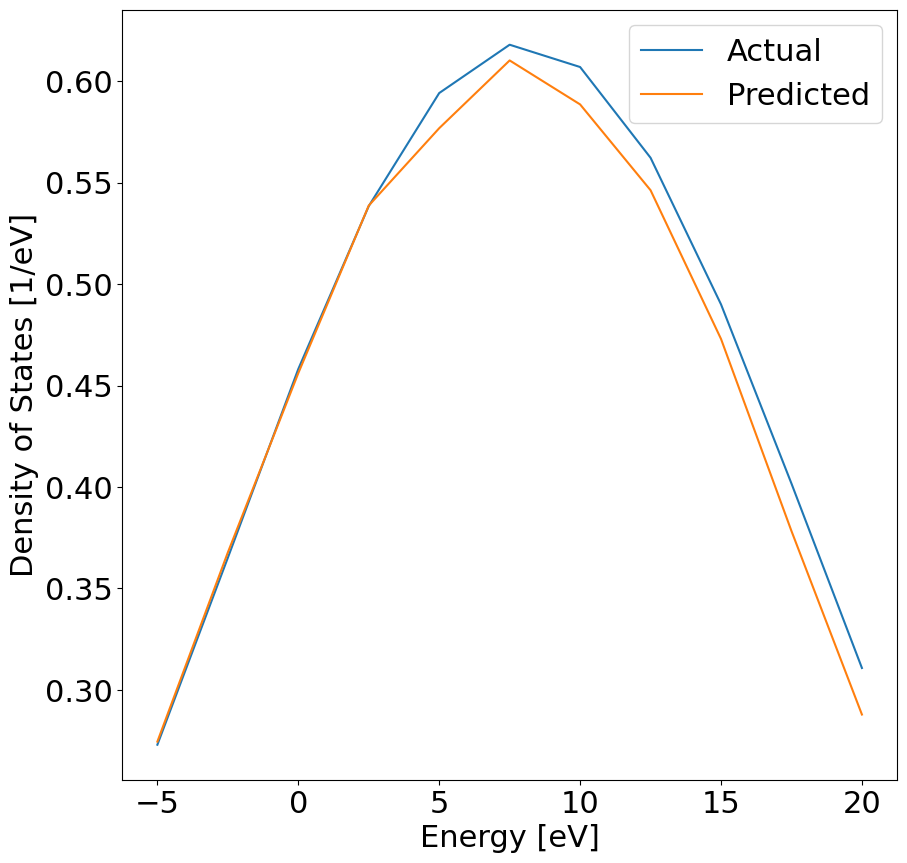

In [73]:
parameters, network, data_handler, tester = mala.Tester.load_run("Be1_model")
data_handler.clear_data()
data_handler.add_snapshot(f"Be_snapshot{test_data[0]}.in.npy", snapshot_path,
                              f"Be_snapshot{test_data[0]}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Be{test_data[0]}.pw.out"))
data_handler.prepare_data(reparametrize_scaler=False)
actual_ldos, predicted_ldos = tester.predict_targets(0)
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()


IMPROVE NN

In [118]:
parameters = mala.Parameters.load_from_file("mala_parameters_01.json")

In [123]:
data_handler = mala.DataHandler(parameters)
prop = 0.6 # proportion of training data
prop2 = 0.3 #proportion of validation data
maxiter = 8 # number of .in snapshots
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data )
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "va")
    
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
#parameters.data.input_rescaling_type = "feature-wise-standard"
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  100,100,
                                  data_handler.output_dimension]


No data rescaling will be performed.
No data rescaling will be performed.
[6 2 7 4] [5 3] [1 8]
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
DONE ADDING DATA ITERATION 8 of 7 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot1.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot1.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking descriptor file  Be_snapshot2.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot2.out.npy at C:\Users\Pablo\Documents\Fisica\Master\

In [124]:
parameters.running.max_number_epochs = 10
parameters.running.early_stopping_epochs = 4

network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()

Initial Guess - validation data loss:  0.23230506049262153
Epoch 0: validation data loss: 3.836002915796607e-05
Epoch 1: validation data loss: 3.856169530237564e-05
Validation accuracy has not improved enough.
Epoch 2: validation data loss: 3.893643316596446e-05
Validation accuracy has not improved enough.
Epoch 3: validation data loss: 3.930020211923002e-05
Validation accuracy has not improved enough.
Epoch 4: validation data loss: 3.880326720801267e-05
Validation accuracy has not improved enough.
Stopping the training, validation accuracy has not improved for 4 epochs.
Final validation data loss:  3.880326720801267e-05


In [125]:
data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Be{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()
results

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot3.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot3.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking descriptor file  Be_snapshot5.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot5.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.
Had to readjust batch size from 10 to 12


{'band_energy': [0.04286269061847037, 0.021863419981007937]}

Now Save Data

In [126]:
trainer.save_run("Be2_model")

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot5.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot5.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


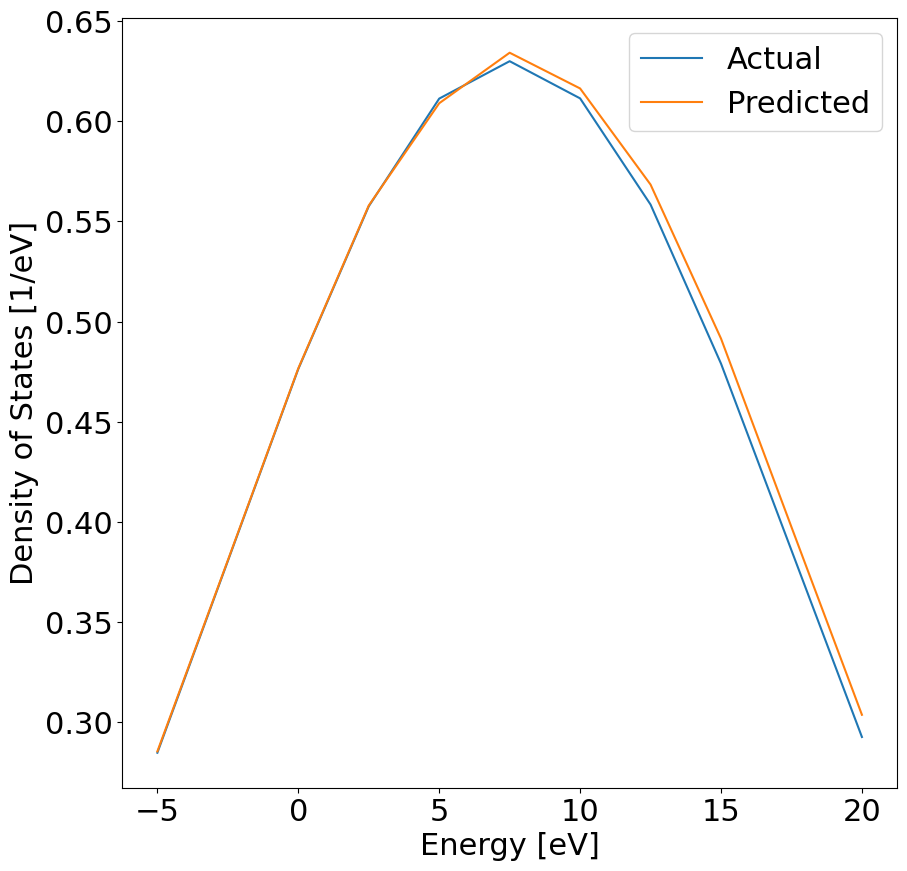

In [127]:
parameters, network, data_handler, tester = mala.Tester.load_run("Be2_model")
data_handler.clear_data()
data_handler.add_snapshot(f"Be_snapshot{test_data[0]}.in.npy", snapshot_path,
                              f"Be_snapshot{test_data[0]}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Be{test_data[0]}.pw.out"))
data_handler.prepare_data(reparametrize_scaler=False)
actual_ldos, predicted_ldos = tester.predict_targets(0)
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()


Let's work now in another material

In [238]:
parameters = mala.Parameters.load_from_file("mala_parameters_01.json")

In [241]:
data_path = r"C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si"
snapshot_path =  r"C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots"

In [242]:
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5
ldos_calculator = mala.LDOS.from_numpy_file(parameters, pj(snapshot_path, "Si_snapshot1.out.npy"))
ldos_calculator.read_additional_calculation_data(pj(data_path, "Si1.pw.out"))
print(ldos_calculator.density_of_states)
print(ldos_calculator.energy_grid)
#print(ldos_calculator.density_of_states)

[0.3503686  0.48364223 0.63366231 0.78783649 0.93219551 1.05337473
 1.13872125 1.17598408 1.15475547 1.0707479  0.93120694]
[-5.  -2.5  0.   2.5  5.   7.5 10.  12.5 15.  17.5 20. ]


Let's plot the DOS

9.108736508805109


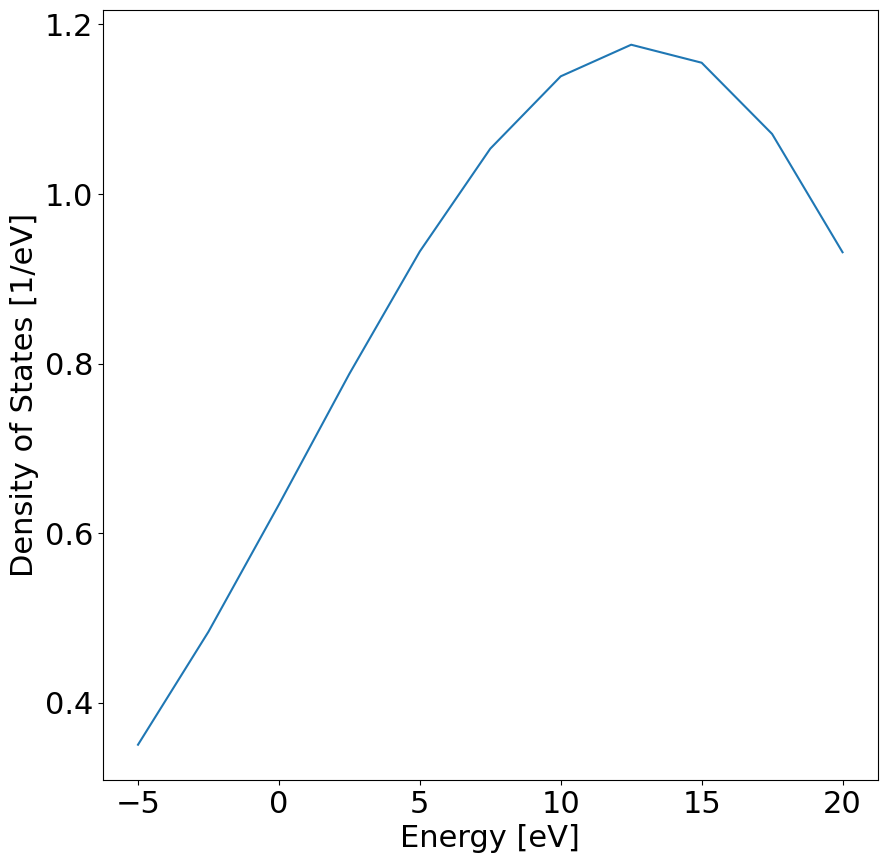

In [243]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states)

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")

print(ldos_calculator.band_energy)

Let's create load data and create the NN


In [245]:
data_handler = mala.DataHandler(parameters)
maxiter = 8
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")
    else:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  100,
                                  data_handler.output_dimension]

No data rescaling will be performed.
No data rescaling will be performed.
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
DONE ADDING DATA ITERATION 8 of 7 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checking targets file  Si_snapshot1.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checking descriptor file  Si_snapshot2.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checking targets file  Si_snapshot2.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\

In [246]:
parameters.running.max_number_epochs = 10
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()

Initial Guess - validation data loss:  0.20487336759214048
Initial Guess - test data loss:  0.2041934978076784
Epoch 0: validation data loss: 7.684290823009278e-05
Epoch 1: validation data loss: 4.825641021684364e-05
Epoch 2: validation data loss: 3.9418223658921544e-05
Epoch 3: validation data loss: 3.5727610035489e-05
Epoch 4: validation data loss: 3.3927764484865795e-05
Epoch 5: validation data loss: 3.29507316497189e-05
Epoch 6: validation data loss: 3.1234086404933975e-05
Epoch 7: validation data loss: 2.9280389383159303e-05
Epoch 8: validation data loss: 2.862890552798355e-05
Epoch 9: validation data loss: 2.8870409113113527e-05
Final validation data loss:  2.8870409113113527e-05
Final test data loss:  7.498501050092905e-06


In [248]:
data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()
results

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot3.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checking targets file  Si_snapshot3.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


{'band_energy': [0.7733000268874406]}

In [250]:
trainer.save_run("Si3_model")

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot3.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checking targets file  Si_snapshot3.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


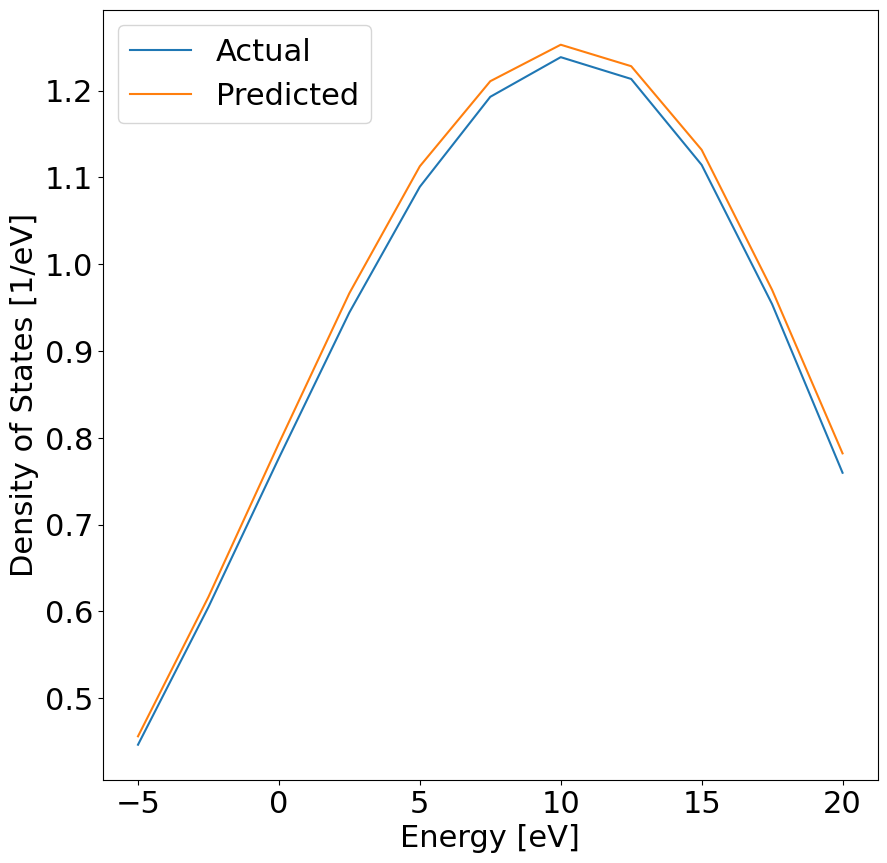

In [251]:
parameters, network, data_handler, tester = mala.Tester.load_run("Si3_model")
data_handler.clear_data()
data_handler.add_snapshot(f"Si_snapshot{test_data[0]}.in.npy", snapshot_path,
                              f"Si_snapshot{test_data[0]}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{test_data[0]}.pw.out"))
data_handler.prepare_data(reparametrize_scaler=False)
actual_ldos, predicted_ldos = tester.predict_targets(0)
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()


In [279]:
data_handler = mala.DataHandler(parameters)
maxiter = 8
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")
    else:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()


No data rescaling will be performed.
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
DONE ADDING DATA ITERATION 8 of 7 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checking targets file  Si_snapshot1.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checking descriptor file  Si_snapshot2.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checking targets file  Si_snapshot2.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checkin

In [280]:
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  500,
                                  data_handler.output_dimension]
parameters.running.early_stopping_epochs = 4
parameters.running.learning_rate = 0.6
#parameters.data.input_rescaling_type = "feature-wise-standard"

parameters.running.max_number_epochs = 10
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()

Initial Guess - validation data loss:  0.23566472795274523
Initial Guess - test data loss:  0.23774387218334056
Epoch 0: validation data loss: 3.47456739594539e-05
Epoch 1: validation data loss: 2.3344060820009973e-05
Epoch 2: validation data loss: 1.989575232275658e-05
Epoch 3: validation data loss: 1.8765415168470807e-05
Epoch 4: validation data loss: 1.8045480828732252e-05
Epoch 5: validation data loss: 1.7584336455911397e-05
Epoch 6: validation data loss: 1.723466104724341e-05
Epoch 7: validation data loss: 1.6989037653224335e-05
Epoch 8: validation data loss: 1.6842482404576408e-05
Epoch 9: validation data loss: 1.6662104624427026e-05
Final validation data loss:  1.6662104624427026e-05
Final test data loss:  2.49685803686993e-06


In [282]:
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5
data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()
results

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot3.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checking targets file  Si_snapshot3.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


{'band_energy': [0.049216807922633166]}

Let's Save the file

In [283]:
trainer.save_run("Si4_model")

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot3.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
Checking targets file  Si_snapshot3.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Si\snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


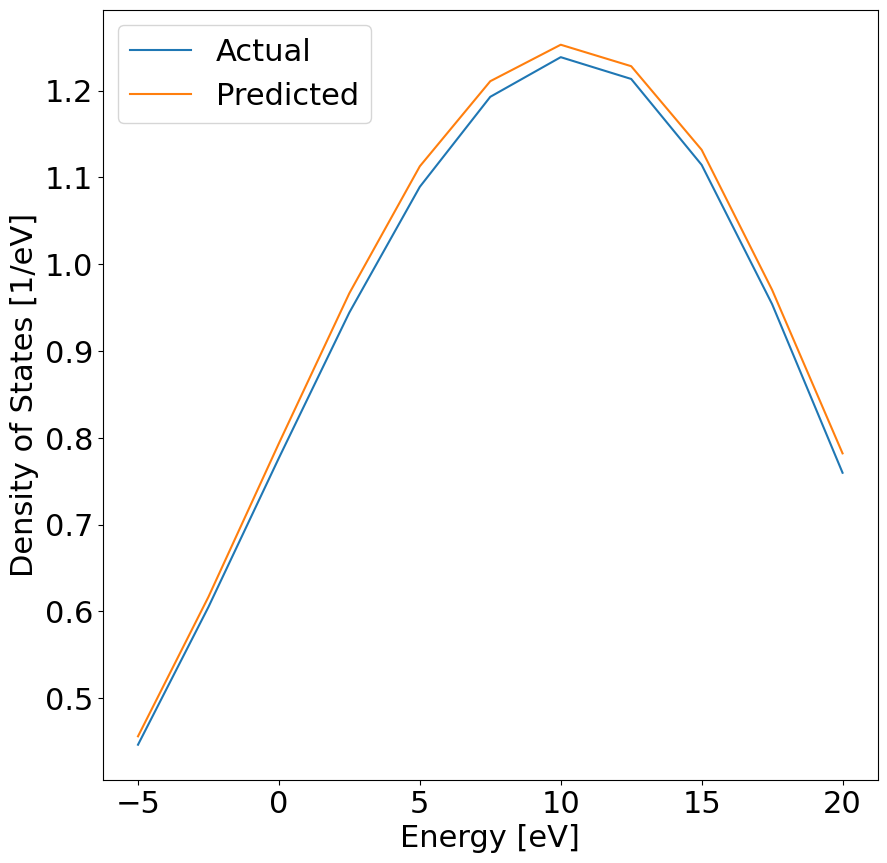

In [284]:
parameters, network, data_handler, tester = mala.Tester.load_run("Si3_model")
data_handler.clear_data()
data_handler.add_snapshot(f"Si_snapshot{test_data[0]}.in.npy", snapshot_path,
                              f"Si_snapshot{test_data[0]}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{test_data[0]}.pw.out"))
data_handler.prepare_data(reparametrize_scaler=False)
actual_ldos, predicted_ldos = tester.predict_targets(0)
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()